<ipython-input-7-a49d77531d56>:156: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, Mag_abs, markerfmt="none", use_line_collection=True)
<ipython-input-7-a49d77531d56>:165: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, Phase, markerfmt="none", use_line_collection=True)


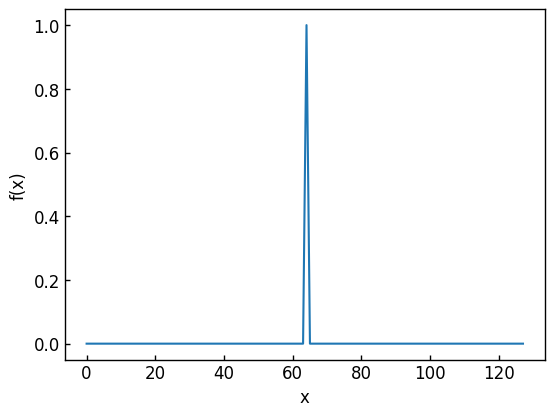

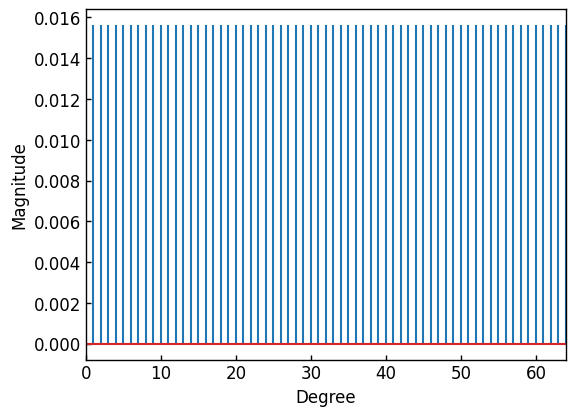

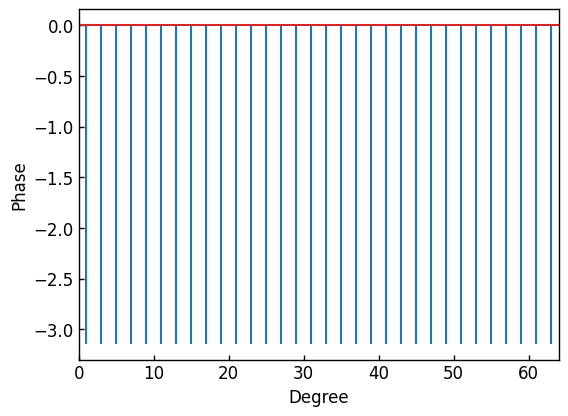

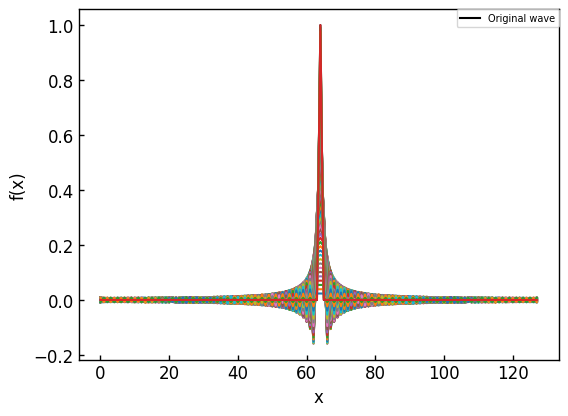

In [7]:
###########################################################################
# 理工学基礎実験B「フーリエ解析と波形の合成」
# 課題１：種々の波形の解析
#
# Original code by Prof. Takanori Uchiyama
# 2022/04/07 Modified by Takuya Tomidokoro
###########################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import glob

######################## プログラムの使い方 ################################
#
# ０．配布されたFourier.zipフォルダを各OS標準の方法で解凍する．
#
# １．入力波形の設定
wave_type = "pulse"     ### この行の" "の中を自分で書き換える．###
#
#     解析する波形を下のリストから選び，上のwave_type = "○○"の○○を書き換える．
#     その後，○○.txtファイルをData/Q1フォルダから選んでアップロードする．
#     ※wave_typeに対応する.txtファイルがアップロードされていないと
#       次のステップでエラーを吐いて止まります．
#     ※「アップロードしたファイルはランタイム時にリサイクルされます」という
#       ポップアップが出た場合はそのままOKしてください．
#
#     ※ data.txtのみ，配布したフォルダ内にはありません．当日，実験室のデジタイザを
#        使って読み取った波形データのファイルをアップロードします．
#        （オンラインでの受講者は，配布されたdata.txtファイルを使用）
#
#           "sin"    : f(x) = sin(x)
#           "sin2"   : f(x) = sin^2(x)
#           "cos"    : f(x) = cos(x)
#           "rect1"  : f(x) = 四角波１
#           "rect2"  : f(x) = 四角波２（波長が短い）
#           "tri1"   : f(x) = 三角波１
#           "tri2"   : f(x) = 三角波２（波長が短い）
#           "pulse"  : f(x) = パルス波（デルタ関数）
#           "saw"    : f(x) = のこぎり波
#           "damped" : f(x) = 減衰波
#           "beat"   : f(x) = うなり
#           "data"   : f(x) = デジタイザで読み取った自分の波形
#
# ２．左上の実行ボタンを押す．出力されるファイルの反映にやや時間がかかるため，
#     フォルダの更新ボタン（リロードマーク付きのファルダのアイコン）を押すとよい．
#
# ３．出力されるファイル（ダブルクリックすると右側に中身を表示）
#   ① Q1_out_(wave_type)_coeffs.csv : 各次数のフーリエ係数，振幅および位相（テキストデータ）
#   ② Q1_out_(wave_type)_recov.csv  : 入力波形，1次から各次数まで順に再構成した波形（テキストデータ）
#   ③ Q1_(wave_type)_amplitude.png  : 振幅スペクトル
#   ④ Q1_(wave_type)_original.png   : 入力波形
#   ⑤ Q1_(wave_type)_phase.png      : 位相スペクトル
#   ⑥ Q1_(wave_type)_recovery.png   : 再構成波形（下の※で指定した次数の範囲）
#
# ４．上の①と②をダウンロードし，中のデータを適宜レポートで使用する．
#     レポートでは，①や②を元にExcelなどでグラフを作成するか，
#     ③～⑥のグラフを適宜ダウンロードして使用してよい．
#     Pythonに挑戦したい／慣れている人は，本プログラムを修正して
#     追加でグラフを作成してもよい．
#     いずれの場合も，作成するグラフは理工学基礎実験の所定の書式に従うこと．
#
# ※ 画像⑥で波形を再構成する次数の範囲は下の数値を書き換えると変更可能．
degree_low   = 1    # 次数の下限 (min. 1)
degree_high  = 64   # 次数の上限 (max. 64)
#
############################################################################

### Delete old output files
def remove_glob(pathname, recursive=True):
    for p in glob.glob(pathname, recursive=recursive):
        if os.path.isfile(p):
            os.remove(p)
remove_glob('/content/*.png')
remove_glob('/content/*.csv')

### Data loading ###
data_path = "/content/"
file_name = data_path + wave_type + ".txt"
data = np.loadtxt(file_name)
data = np.array(data)
if wave_type != 'data':
    data = data[:,1]

### Parameter setting ###
NFFT = len(data) # Data length
Sa = 128
Fs = 1/Sa

### Save plot/data to image_file/data_file ###
image_file_name_original = data_path + "Q1_" + wave_type + "_original.png"
image_file_name_amplitude = data_path + "Q1_" + wave_type + "_amplitude.png"
image_file_name_phase = data_path + "Q1_" + wave_type + "_phase.png"
image_file_name_recovery = data_path + "Q1_" + wave_type + "_recovery.png"
save_file1 = data_path + "Q1_out_" + wave_type + "_coeff.csv"
save_file2 = data_path + "Q1_out_" + wave_type + "_recov.csv"

### FFT ###
Mag = np.fft.fft(data,NFFT)
an = Mag.real*2/NFFT
bn = -Mag.imag*2/NFFT
Mag_abs = np.sqrt(an**2+bn**2)
Phase = np.arctan2(bn,an)
Mag_abs[0] = 0

### Save Fourier series parameters (Q1_out_(wave_type)_coeffs.csv) ###
header1 =  'n, an, bn, An, phi_n'
save_data1 = [range(0,len(an)), an, bn, Mag_abs, Phase]
save_data1 = np.array(save_data1)
save_data1 = save_data1.T
DNUM = int(Sa/2) + 1
save_data1 = save_data1[:DNUM,:]
np.savetxt(save_file1, save_data1, header=header1, delimiter=',', fmt="%.5f", comments='')

### Save recovery profiles (Q1_out_(wave_type)_recov.csv) ###
DNUM = int(Sa/2)
save_data2 = np.arange(NFFT)
save_data2 = np.c_[save_data2,data]
for n in range(DNUM):
    Mag_tmp = np.fft.fft(data,NFFT)
    Mag_tmp[:degree_low-1] = 0
    Mag_tmp[degree_low+n+1:] = 0
    r = np.fft.irfft(Mag_tmp,NFFT)
    save_data2 = np.c_[save_data2,r]

header2 = 'x' + ',' + 'original'
for n in range(DNUM):
    header2 = header2 + ',' + 'degree' + str(n+1)

np.savetxt(save_file2, save_data2, header=header2, delimiter=',', fmt="%.5f", comments='')

### Create figures ###

plt.rcParams['xtick.direction'] = 'in'  # x scale direction
plt.rcParams['ytick.direction'] = 'in'  # y scale direction
plt.rcParams['xtick.major.width'] = 1.0 # y scale line width
plt.rcParams['ytick.major.width'] = 1.0 # y scale line width
plt.rcParams['font.size'] = 12          # font size
plt.rcParams['axes.linewidth'] = 1.0    # line width
plt.rcParams['figure.subplot.left'] =   0.15 # margin %
plt.rcParams['figure.subplot.bottom'] = 0.15 # margin %

# Q1_(wave_type)_original.png
fig1 = plt.figure()
plt.plot(data)
plt.xlabel('x')
plt.ylabel('f(x)')
if wave_type == 'data':
  plt.ylim(0,2400)
fig1.savefig(image_file_name_original)

# Q1_(wave_type)_amplitude.png
fig2 = plt.figure()
x = np.arange(NFFT)
plt.stem(x, Mag_abs, markerfmt="none", use_line_collection=True)
plt.xlim(0,Sa/2)
plt.xlabel('Degree')
plt.ylabel('Magnitude')
fig2.savefig(image_file_name_amplitude)

# Q1_(wave_type)_phase.png
fig3 = plt.figure()
x = np.arange(NFFT)
plt.stem(x, Phase, markerfmt="none", use_line_collection=True)
plt.xlim(0,Sa/2)
plt.xlabel('Degree')
plt.ylabel('Phase')
fig3.savefig(image_file_name_phase)

# Q1_(wave_type)_recovery.png
NUM = degree_high-degree_low+1
fig4 = plt.figure()
plt.plot(data,'k',label='Original wave')
for n in range(NUM):
    Mag_tmp = np.fft.fft(data,NFFT)
    Mag_tmp[:degree_low-1] = 0
    Mag_tmp[degree_low+n+1:] = 0
    r = np.fft.irfft(Mag_tmp,NFFT) # signal recovery
#    l = "degree:" + str(degree_low+n)
#    plt.plot(r, label=l)
    plt.plot(r)
plt.xlabel('x')
plt.ylabel('f(x)')
if wave_type == 'data':
  plt.ylim(0,2400)
plt.legend(borderaxespad=0, fontsize=7)
fig4.savefig(image_file_name_recovery)
